Blind source separation¶
The purpose of the project is to separate an image obtained as a sum of a two images into its components.

The two images img1 and img2 summed together come from different dataset: mnist and fashion_mnist, respectively.

No preprocessing is allowed. The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2.

The metric used to evaluate the project is the mean squared error between predicted and ground truth images

In [14]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

import numpy as np
from matplotlib import pyplot as plt

Here we load the two datasets, mnist and fashion mnist (both in grayscale).

For simplicity, the samples are padded to dimension (32,32).

In [15]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

(60000, 28, 28)
(60000, 32, 32)


In [16]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


Here is a simple datagenerator.

In [17]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data 

Here we define two generators, one for training and one for testing. You may possibly add an addition generator for validation, further splitting the dataset.

In [18]:
batchsize = 16
inputShape = (32,32,1)

In [19]:
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,batchsize)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,batchsize)
validation_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,batchsize)

This is the X_train image or the input image to the model


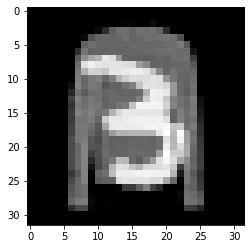

This is the desired output


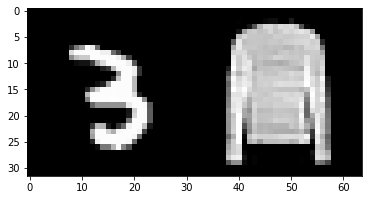

(32, 32)
(32, 64)
(16, 32, 32)


In [20]:
x, y = next(train_generator)
plt.imshow(x[0],cmap='gray', interpolation='nearest')
print("This is the X_train image or the input image to the model")
plt.show()
plt.imshow(y[0], cmap='gray', interpolation='nearest')
print("This is the desired output")
plt.show()

print(x[0].shape)
print(y[0].shape)
print(x.shape)

# 

In [21]:
def build_model():
  input = layers.Input(shape=(32, 32, 1))

  # Encoder
  x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(input)
  x = layers.ReLU()(x)
    # 15 layers, Conv+BN+relu
  for i in range(15):
    x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)   
    # last layer, Conv
  x = layers.Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same')(x)
  output1 = layers.Subtract()([input, x])

  # Encoder
    # 1st layer, Conv+relu
  x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(input)
  x = layers.ReLU()(x)
    # 15 layers, Conv+BN+relu
  for i in range(15):
    x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)   
    # last layer, Conv
  x = layers.Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same')(x)
  output2 = layers.Subtract()([input, x])   # input - noise


  y = layers.Concatenate(axis=2)([output1,output2])
  # Autoencoder
  autoencoder = Model(input, y)
  return autoencoder



In [ ]:
autoencoder=build_model()

In [22]:
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_34 (Conv2D)             (None, 32, 32, 64)   640         ['input_2[0][0]']                
                                                                                                  
 conv2d_51 (Conv2D)             (None, 32, 32, 64)   640         ['input_2[0][0]']                
                                                                                                  
 re_lu_32 (ReLU)                (None, 32, 32, 64)   0           ['conv2d_34[0][0]']              
                                                                                            

In [23]:
autoencoder.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mean_squared_error',
                 metrics=['mse','accuracy'])

In [24]:
history=autoencoder.fit(train_generator, batch_size=batchsize, epochs=30,steps_per_epoch=20000,validation_steps= 20000,validation_data=validation_generator, workers=6, shuffle=True,use_multiprocessing=True)

Epoch 1/30
20000/20000 [==============================] - 709s 35ms/step - loss: 0.0037 - mse: 0.0037 - accuracy: 0.7413 - val_loss: 0.0013 - val_mse: 0.0013 - val_accuracy: 0.7404
Epoch 2/30
20000/20000 [==============================] - 702s 35ms/step - loss: 8.8949e-04 - mse: 8.8949e-04 - accuracy: 0.7411 - val_loss: 0.0010 - val_mse: 0.0010 - val_accuracy: 0.7405
Epoch 3/30
20000/20000 [==============================] - 701s 35ms/step - loss: 6.8332e-04 - mse: 6.8332e-04 - accuracy: 0.7421 - val_loss: 7.7094e-04 - val_mse: 7.7094e-04 - val_accuracy: 0.7406
Epoch 4/30
20000/20000 [==============================] - 701s 35ms/step - loss: 6.1120e-04 - mse: 6.1120e-04 - accuracy: 0.7419 - val_loss: 7.1027e-04 - val_mse: 7.1027e-04 - val_accuracy: 0.7406
Epoch 5/30
20000/20000 [==============================] - 701s 35ms/step - loss: 5.5710e-04 - mse: 5.5710e-04 - accuracy: 0.7419 - val_loss: 6.8868e-04 - val_mse: 6.8868e-04 - val_accuracy: 0.7406
Epoch 6/30
20000/20000 [===============

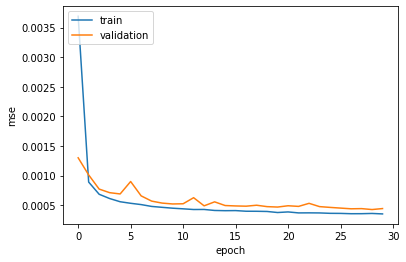

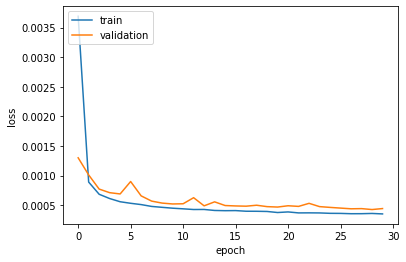

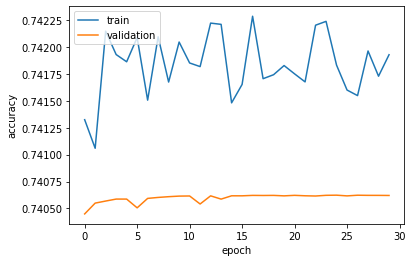

In [25]:
import matplotlib.pyplot as plt

def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

#plot_history
plot_history(history,['mse','val_mse'])
plot_history(history,['loss','val_loss'])
plot_history(history,['accuracy','val_accuracy'])


In [26]:
y_pred = autoencoder.predict(test_generator,steps=20000)
print(y_pred.shape)

(320000, 32, 64, 1)


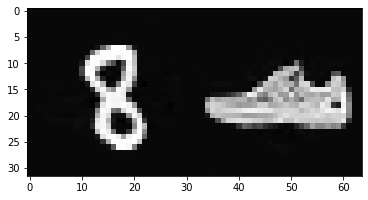

In [27]:

plt.imshow(y_pred[0].reshape(32, 64),cmap='gray', interpolation='nearest')
plt.show()



In [28]:
autoencoder.save('/weights/bss.h5')

In [29]:
mse = np.zeros(10)
for i in range(10):
  mse[i] = autoencoder.evaluate(test_generator,steps=20000)[1]

mean_mse = mse.mean()
std = mse.std()

20000/20000 [==============================] - 217s 11ms/step - loss: 4.4189e-04 - mse: 4.4189e-04 - accuracy: 0.7407


In [30]:
print(autoencoder.evaluate(test_generator,steps=20000))

print("Mean mse: ",mean_mse)

print("Standard deviation : ",std)

20000/20000 [==============================] - 217s 11ms/step - loss: 4.4044e-04 - mse: 4.4044e-04 - accuracy: 0.7406
[0.00044044083915650845, 0.00044044083915650845, 0.7406299710273743]
Mean mse:  0.0004418350727064535
Standard deviation :  8.866407534857386e-07
